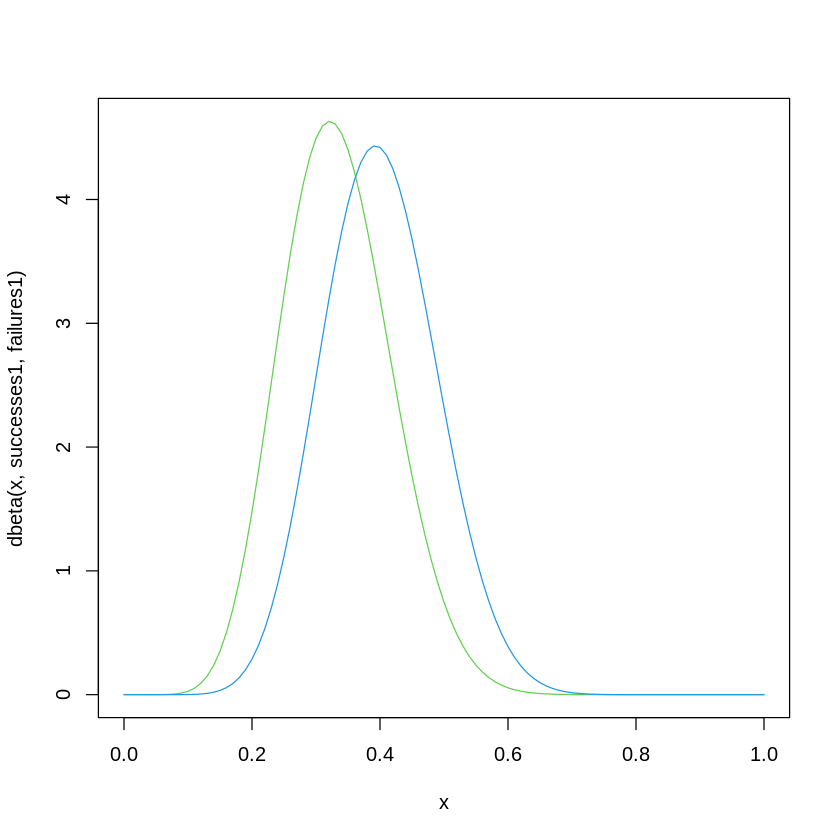

In [ ]:
# Demo of 2 beta distributions (e.g. for an A/B test), based on the number of successess/failures (e.g. conversions/non-conversions) for each
# Multi-arm bandit algorithm is to pick a number randomly from each distribution, and then use the variant with the larger number 
# Depending on what the user does, increment the relevant one of the four values below based on the result
# Over time the distributions get taller and skinnier as the sample sizes grow
successes1 <- 10
failures1 <- 20
successes2 <- 12
failures2 <- 18

x <- seq(0,1,by=0.01)
plot(x, dbeta(x,successes1,failures1), type="l", col=3)
lines(x, dbeta(x,successes2,failures2), col=4)

In [ ]:
# Function to simulate a run through a test given p-values for A and B respectively, a sample size, and a percentage of the traffic to use as an exploration phase
runTest <- function (p1, p2, n, explore) {
  # Set equal initial beta distribtion values for both variations
  # Make sure all > 0 so works for any explore value
  alpha1 <- 2
  beta1 <- 2
  alpha2 <- 2 
  beta2 <- 2
  
  # Play!
  for(i in 1:n) {
    # Pick which bandit to use, initially by exploratory phase, then using beta distributions
    temp1 <- 0
    temp2 <- 0
    while(temp1 == temp2) {
      if(i < n*explore) {
        temp1 <- rnorm(1)
        temp2 <- rnorm(1)
      } else {
        temp1 <- rbeta(1,alpha1,beta1)
        temp2 <- rbeta(1,alpha2,beta2)
      }
    }
    # Use the winner for this iteration
    if(temp1 > temp2) {
      # Based on the real p-value for variant 1 (which we don't know in real life), simulate a bernoulli outcome
      test <- rbinom(1,1,p1)
      
      # Update the successes/failures accordingly
      if(test == 1) {
        alpha1 <- alpha1 + 1
      } else {
        beta1 <- beta1 + 1
      }
    } else if(temp2 > temp1) {
      # Or, if variant 2 was the winner for this iteration, repeat using the p-value for variant 2
      test <- rbinom(1,1,p2)
      if(test == 1) {
        alpha2 <- alpha2 + 1
      } else {
        beta2 <- beta2 + 1
      }
    }
  }
  
  alpha1 <- alpha1 - 2
  alpha2 <- alpha2 - 2
  beta1 <- beta1 - 2
  beta2 <- beta2 - 2
  
  mean1 <- alpha1 / (alpha1 + beta1)
  mean2 <- alpha2 / (alpha2 + beta2)
  if(mean1 > mean2) {
    return(c(1,alpha1,beta1,alpha2,beta2))
  } else if(mean2 > mean1) {
    return(c(2,alpha1,beta1,alpha2,beta2))
  } else {
    return(c(0,alpha1,beta1,alpha2,beta2))
  }
}

In [ ]:
# Simulation of a test for A vs. B if run a number of times to show how might work out in practice

# First set p values for variants 1 and 2
p1 <- 0.003 # Approx values for verizonconnect.com based on previous deals/traffic?
p2 <- 0.0035

# Estimated sample size comparison at different powers/significance levels
print(power.prop.test(n=NULL, p1=p1, p2=p2, sig.level=0.05, power=0.8, alternative='two.sided'))
print(power.prop.test(n=NULL, p1=p1, p2=p2, sig.level=0.5, power=0.9, alternative='two.sided'))


     Two-sample comparison of proportions power calculation 

              n = 203406.5
             p1 = 0.003
             p2 = 0.0035
      sig.level = 0.05
          power = 0.8
    alternative = two.sided

NOTE: n is number in *each* group


     Two-sample comparison of proportions power calculation 

              n = 99153.98
             p1 = 0.003
             p2 = 0.0035
      sig.level = 0.5
          power = 0.9
    alternative = two.sided

NOTE: n is number in *each* group



In [ ]:
# Set n (sample size), explore ratio, and number of simulations
n <- 99153.98 # note that about 90,000 users per month of traffic in NA
explore <- 0.2 # what proportion of n to stay at 50/50 (i.e. exploration) before using beta distributions to weight the leading variant
k <- 100
zero <- 0
one <- 0
two <- 0
winner <- double(k)
alpha1 <- double(k)
alpha2 <- double(k)
beta1 <- double(k)
beta2 <- double(k)

# Run k simulations of test and record the winners
for(i in 1:k){
  result <- runTest(p1,p2,n,explore)
  if(result[1] == 0) {
    zero <- zero + 1
  } else if(result[1] == 1) {
    one <- one + 1
  } else if(result[1] == 2) {
    two <- two + 1
  }
  winner[i] <- result[1]
  alpha1[i] <- result[2]
  beta1[i] <- result[3]
  alpha2[i] <- result[4]
  beta2[i] <- result[5]
}

print(paste0("A: ", one, " wins, used on average ", round((sum(alpha1) + sum(beta1))/(n*k) * 100, digits=1), "% of the time"))
print(paste0("B: ", two, " wins, used on average ", round((sum(alpha2) + sum(beta2))/(n*k) * 100, digits=1), "% of the time"))
print(paste0("Even: ", zero, " times"))

[1] "A: 11 wins, used on average 29.7% of the time"
[1] "B: 89 wins, used on average 70.3% of the time"
[1] "Even: 0 times"
